## Прогноз по ETHEREUM

Необходимо разработать модель для прогнозирования финансового показателя (например, цены акции) на основе временного ряда. При построении нейросети необходимо использовать
архитектуру/слои LSTM.
Проект должен включать этапы предобработки данных, создания модели и анализа результатов.

**Данные**:
необходимо использовать один из следующих открытых датасетов: Yahoo Finance, Quandl, Kaggle или другие.

<a id='К-содержанию'></a>  
**Содержание проекта**  
[Загрузка и предобработка данных.](#Загрузка-и-предобработка-данных.)  
[Разделение данных на обучающую и тестовую выборки.](#Разделение-данных-на-обучающую-и-тестовую-выборки.)  
[Создание модели LSTM с использованием PyTorch и обучение.](#Создание-модели-LSTM-с-использованием-PyTorch-и-обучение.)  
[Прогноз на тестовой выборке. Расчет метрик качества.](#Прогноз-на-тестовой-выборке.-Расчет-метрик-качества.)  
[Визуализация результатов и сравнение прогноза модели с реальными значениями.](#Визуализация-результатов-и-сравнение-прогноза-модели-с-реальными-значениями.)  
[Общий вывод.](#Общий-вывод.)  

In [1]:
%%capture
!pip install ccxt
!pip install torch

In [2]:
#импортируем библиотеки перед началом проекта одним блоком
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats as st
import ccxt


# исследование и анализ временного ряда + визуализация
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# загружаем нужные модели
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

# загружаем функции для работы с метриками
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
# зададим стандарт датафрейма перед загрузкой
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# пара функций для анализа временных рядов

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


# функция добавления признаков

def make_features(data, max_lag, rolling_mean_size, column):
    new_features = pd.DataFrame(index=data.index)
    
    # лаги
    #for lag in range(1, max_lag + 1):
    #    new_features[f'{column}_lag_{lag}'] = data[column].shift(lag)
    new_features[f'{column}_lag_{max_lag}'] = data[column].shift(max_lag)

    # скользяшки
    #for window in range(rolling_mean_size, rolling_mean_size * 3 + 1, rolling_mean_size):
    #    new_features[f'{column}_rolling_mean_{window}'] = data[column].shift(1).rolling(window).mean()
    new_features[f'{column}_rolling_mean_{rolling_mean_size}'] = data[column].shift(1).rolling(rolling_mean_size).mean()


    # максимумы и минимумы за 24 часа
    #data[f'{column}_max_rolling_24'] = data[column].rolling(window=24).max()
    #data[f'{column}_min_rolling_24'] = data[column].rolling(window=24).min()
    #data[f'{column}_max_min_range'] = data[f'{column}_max_rolling_24'] - data[f'{column}_min_rolling_24']
    data[f'{column}_max_min_range'] = data[column].shift(1).rolling(window=24).max() - data[column].shift(1).rolling(window=24).min()

    return new_features

# вывод гистограммы и boxplot
def line_box(data,column,m=10,n=2):
    
    palette = sns.color_palette('hsv', n_colors=10)
    random_color = random.choice(palette)
        
    fig, axes = plt.subplots(1, 2, figsize=(m, n), gridspec_kw={'width_ratios': [3, 2]}) 
    ax = axes[0]
    sns.lineplot(data=data, x=data.index, y=column, 
                    color=random_color,
                    alpha=0.6,
                    legend='auto', ax=ax)
    ax.set_xticks([])
    ax.set_xlabel('time period')

    ax = axes[1]
    sns.boxplot(x=data[column], color=random_color, ax=ax)
    ax.set_ylabel('')

    plt.tight_layout()
    plt.show();

<a id='Загрузка-и-предобработка-данных.'></a> 
## Загрузка и предобработка данных.
[К содержанию](#К-содержанию) 

Проведя небольшое исследование, выяснилось, что intraday-данные с Quandl и его основного конкурента Alpha_vantage только по платной подписке, Yahoo finance дает неполные данные и только по неактуальным парам - криптовалюта/фиатная валюта(кто и где это торгует?), investing.com также дает только дневки и на ограниченный период. Поэтому был выбран вариант использования данных по паре ETH/USDT напрямую с Binance: 

In [4]:
# проверим наличие файла с данными, если нет, то осуществим загрузку часовых данных по ETH с помощью библиотеки ccxt

pth = 'eth_h.csv'
ticker = 'ETH/USDT'
start_date = "2024-06-14"
end_date = "2024-12-14"


try:
    if os.path.exists(pth):
        data = pd.read_csv(pth, index_col=0)
        print('Загружен датасет из локального источника')
    else:
        # загружаем данные с Binance
        exchange = ccxt.binance()

        # переводим даты в timestamp
        start_timestamp = exchange.parse8601(start_date + "T00:00:00Z")
        end_timestamp = exchange.parse8601(end_date + "T23:59:59Z")

        # получаем данные, т.к. binance отдает по 1000 строк, придется получать данные несколькими запросами и склеивать
        ohlcv = []
        since = start_timestamp
        while since < end_timestamp:
            data = exchange.fetch_ohlcv(ticker, timeframe='1h', since=since, limit=1000)
            if len(data) == 0:
                break
            ohlcv.extend(data)
            since = data[-1][0] + 3600000  #шаг 1000 часов

        data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
        data.set_index('timestamp', inplace=True)
        data.index.name = None

        # сохраняем данные
        data.to_csv(pth)
        print(f'Данные загружены с Binance и сохранены в {pth}')
        
except Exception as e:
    print(f'Не получилось загрузить или скачать данные. Ошибка: {e}')

data.head()

Загружен датасет из локального источника


,open,high,low,close,volume
2024-06-14 00:00:00,3469.40,3479.14,3461.40,3473.47,7072.3545
2024-06-14 01:00:00,3473.47,3488.60,3457.37,3487.04,8548.1420
2024-06-14 02:00:00,3487.04,3509.64,3480.39,3505.61,10011.1434
2024-06-14 03:00:00,3505.61,3510.53,3489.13,3490.91,8365.9114
2024-06-14 04:00:00,3490.91,3500.00,3490.46,3496.80,6644.6749


In [5]:
# проверим данные на хронологический порядок и пропуски в индексе
if data.index.is_monotonic_increasing:
    print('Хронологический порядок в индексе сохраняется\n')
else:
    print('Хронологический порядок в индексе нарушен\n')

# проверим данные на пропуски
print('Количество пропусков в датасете:\n', data.isna().sum(), sep='')

# проверим данные на дубликаты в индекске
print('\nКоличество дубликатов в индексе: ', data.index.duplicated(keep=False).sum(),'\n')

# посмотрим на типы данных
print(data.info(),'\n')

# преобразуем индекс к Datetime
data.index = pd.to_datetime(data.index)
print(type(data.index))

Хронологический порядок в индексе сохраняется

Количество пропусков в датасете:
open      0
high      0
low       0
close     0
volume    0
dtype: int64

Количество дубликатов в индексе:  0 

<class 'pandas.core.frame.DataFrame'>
Index: 4461 entries, 2024-06-14 00:00:00 to 2024-12-16 20:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    4461 non-null   float64
 1   high    4461 non-null   float64
 2   low     4461 non-null   float64
 3   close   4461 non-null   float64
 4   volume  4461 non-null   float64
dtypes: float64(5)
memory usage: 209.1+ KB
None 

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Значения столбцов исходных данных:


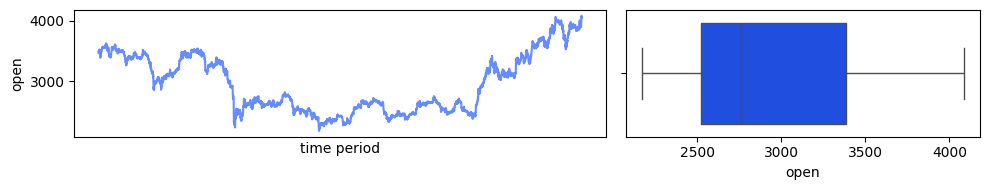

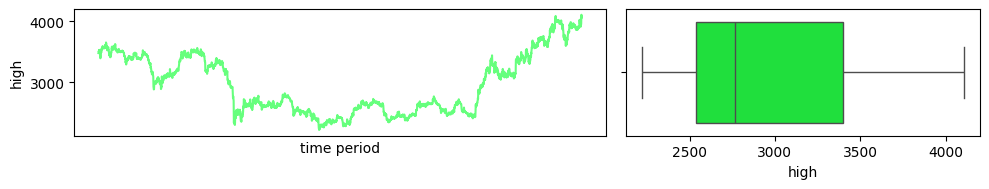

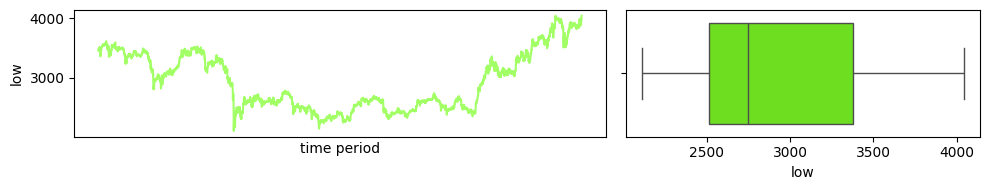

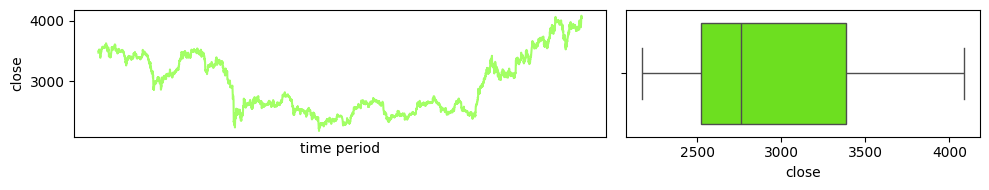

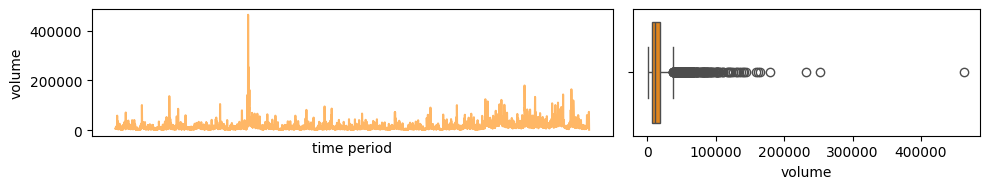

In [6]:
# построим графики линейный и боксплот для каждого столбца для поиска выбросов

print('Значения столбцов исходных данных:')
for column in data.columns:
    line_box(data,column)  


Выбросы наличествуют только по объемам и по времени совпадают с периодом сильного падения цены, что закономерно для финансовых рынков, исключать данные не будем.

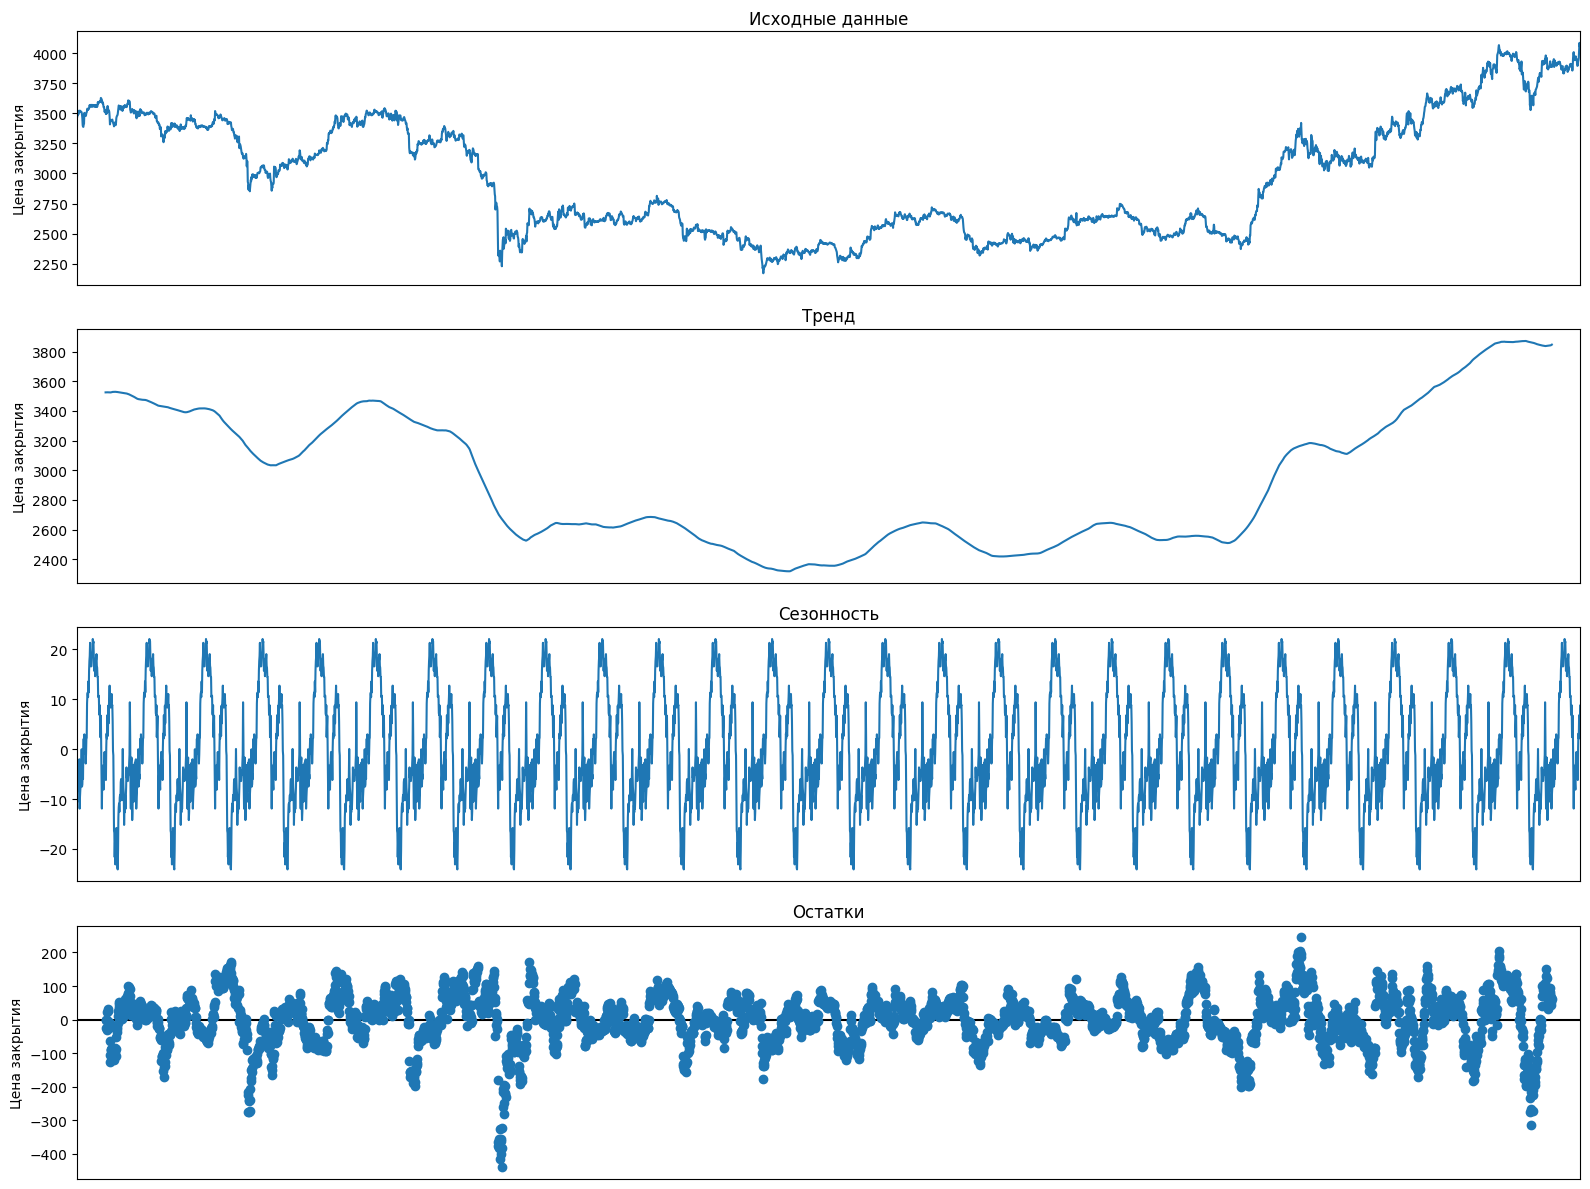

In [7]:
# выделим трендовую и сезонную составляющие, а также остатки по закрытиям часов (столбец close)
result = seasonal_decompose(data['close'], model='additive', period = 168) # для наглядности скользящее среднее для тренда указали в 168 часов = 1 неделя

# построение графиков
fig = result.plot()
fig.set_size_inches((16, 12))

# убираем метки оси X на всех графиках
for ax in fig.axes:
    ax.set_xticks([])

fig.axes[0].set_title('Исходные данные')
fig.axes[0].set_ylabel('Цена закрытия')

fig.axes[1].set_title('Тренд')
fig.axes[1].set_ylabel('Цена закрытия')

fig.axes[2].set_title('Сезонность')
fig.axes[2].set_ylabel('Цена закрытия')

fig.axes[3].set_title('Остатки')
fig.axes[3].set_ylabel('Цена закрытия')

plt.tight_layout()
plt.show()

Ряды признаков явно нестационарны, что в целом общеизвестно, но можно провести пару статтестов для убедительности:

- для ADF:
    * нулевая гипотеза: ряд имеет единичный корень (ряд не является стационарным)
    * альтернативная гипотеза: ряд не имеет единичного корня;  
а = 0.05, 0.01, если нулевую гипотезу не удалось отвергнуть, этот тест может свидетельствовать о нестационарности ряда.  

- для KPSS гипотезы обратные:
    * нулевая гипотеза: процесс является стационарным
    * альтернативная гипотеза: ряд имеет единичный корень (ряд не является стационарным);  
а = 0.05, 0.01, если нулевую гипотезу не удалось отвергнуть, этот тест может свидетельствовать о стационарности ряда.

In [8]:
# проведем тест Дики-Фуллера (ADF)
adf_test(data['close'])

Results of Dickey-Fuller Test:
Test Statistic                   -0.614123
p-value                           0.867759
Lags Used                        26.000000
Number of Observations Used    4434.000000
Critical Value (1%)              -3.431826
Critical Value (5%)              -2.862192
Critical Value (10%)             -2.567117
dtype: float64


In [9]:
# проведем тест KPSS
kpss_test(data['close'])

Results of KPSS Test:
Test Statistic            2.242788
p-value                   0.010000
Lags Used                41.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/var/folders/yf/tnhxwgts2035718d0nhj30rw0000gn/T/ipykernel_82378/1418574189.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Вывод по **стационарности** - 
- по тесту ADF полученное значение p-value значительно превышает заданный уровень значимости 0.05, что может свидетельствовать о нестационарности ряда;
- по тесту KPSS полученное p-value (с учетом комментария системы) меньше обоих стандартных порогов значимости, таким образом данный тест очевидно характеризует ряд как нестационарный;
- с учетом очевидного наличия трендов, сезонности и явной структцры в остатках, а также результатов тестов, можем охарактеризовать ряд как нестационарный. 

In [10]:
# с учетом необходимости предсказания будущего close необходимо скорректировать целевую переменную
# заодно добавить признак open текущей свечи (т.к. high и low в текущей свече неизвестны, а close текущей свечи прогнозируем)

display(data.tail())

data['open_actual'] = data['open'].shift(-1)
data['close_actual'] = data['close'].shift(-1)

display(data.tail())

data = data.dropna()

,open,high,low,close,volume
2024-12-16 16:00:00,3941.21,3973.00,3939.40,3962.41,31949.4036
2024-12-16 17:00:00,3962.42,4042.11,3958.60,4033.70,66377.4354
2024-12-16 18:00:00,4033.70,4107.80,4031.71,4086.66,73953.7892
2024-12-16 19:00:00,4086.66,4088.22,4033.24,4056.88,48001.6435
2024-12-16 20:00:00,4056.89,4061.49,4042.55,4048.54,2344.0555


,open,high,low,close,volume,open_actual,close_actual
2024-12-16 16:00:00,3941.21,3973.00,3939.40,3962.41,31949.4036,3962.42,4033.70
2024-12-16 17:00:00,3962.42,4042.11,3958.60,4033.70,66377.4354,4033.70,4086.66
2024-12-16 18:00:00,4033.70,4107.80,4031.71,4086.66,73953.7892,4086.66,4056.88
2024-12-16 19:00:00,4086.66,4088.22,4033.24,4056.88,48001.6435,4056.89,4048.54
2024-12-16 20:00:00,4056.89,4061.49,4042.55,4048.54,2344.0555,NaN,NaN


In [11]:
# сгенерируем дополнительные признаки по типовым лекалам

data_af = make_features(data, 1, 8, 'close')
data = pd.concat([data, data_af], axis=1)

# дни недели
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek

# разницы и отношения
data['closeopen'] = data['close']-data['open']
data['highlow'] = data['high']-data['low']
data['open_to_close_ratio'] = data['open'] / data['close']
data['high_to_low_ratio'] = data['high'] / data['low']

# волатильность
data['volatility_24'] = data['close'].rolling(window=24).std()

# индикатор RSI
delta = data['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# сила объема
data['volume_to_avg_volume_ratio'] = data['volume'] / data['volume'].rolling(window=24).mean()

data = data.dropna()    

data.head()

,open,high,low,close,volume,open_actual,close_actual,close_max_min_range,close_lag_1,close_rolling_mean_8,day,dayofweek,closeopen,highlow,open_to_close_ratio,high_to_low_ratio,volatility_24,RSI,volume_to_avg_volume_ratio
2024-06-15 00:00:00,3481.80,3500.85,3478.46,3492.56,10546.3270,3492.56,3477.78,134.91,3481.80,3433.87375,15,5,10.76,22.39,0.996919,1.006437,44.961008,46.438351,0.776916
2024-06-15 01:00:00,3492.56,3503.03,3476.90,3477.78,5048.3205,3477.78,3485.00,134.91,3492.56,3445.04250,15,5,-14.78,26.13,1.004250,1.007515,44.944383,43.506627,0.375933
2024-06-15 02:00:00,3477.78,3489.01,3473.10,3485.00,3571.0606,3485.00,3504.40,134.91,3477.78,3456.06250,15,5,7.22,15.91,0.997928,1.004581,44.636818,45.252505,0.271348
2024-06-15 03:00:00,3485.00,3505.01,3485.00,3504.40,7998.6678,3504.40,3509.00,134.91,3485.00,3468.23750,15,5,19.40,20.01,0.994464,1.005742,44.871037,49.481058,0.608489
2024-06-15 04:00:00,3504.40,3516.00,3498.29,3509.00,16377.2350,3509.00,3526.91,134.91,3504.40,3480.51125,15,5,4.60,17.71,0.998689,1.005062,45.137193,53.366760,1.208593


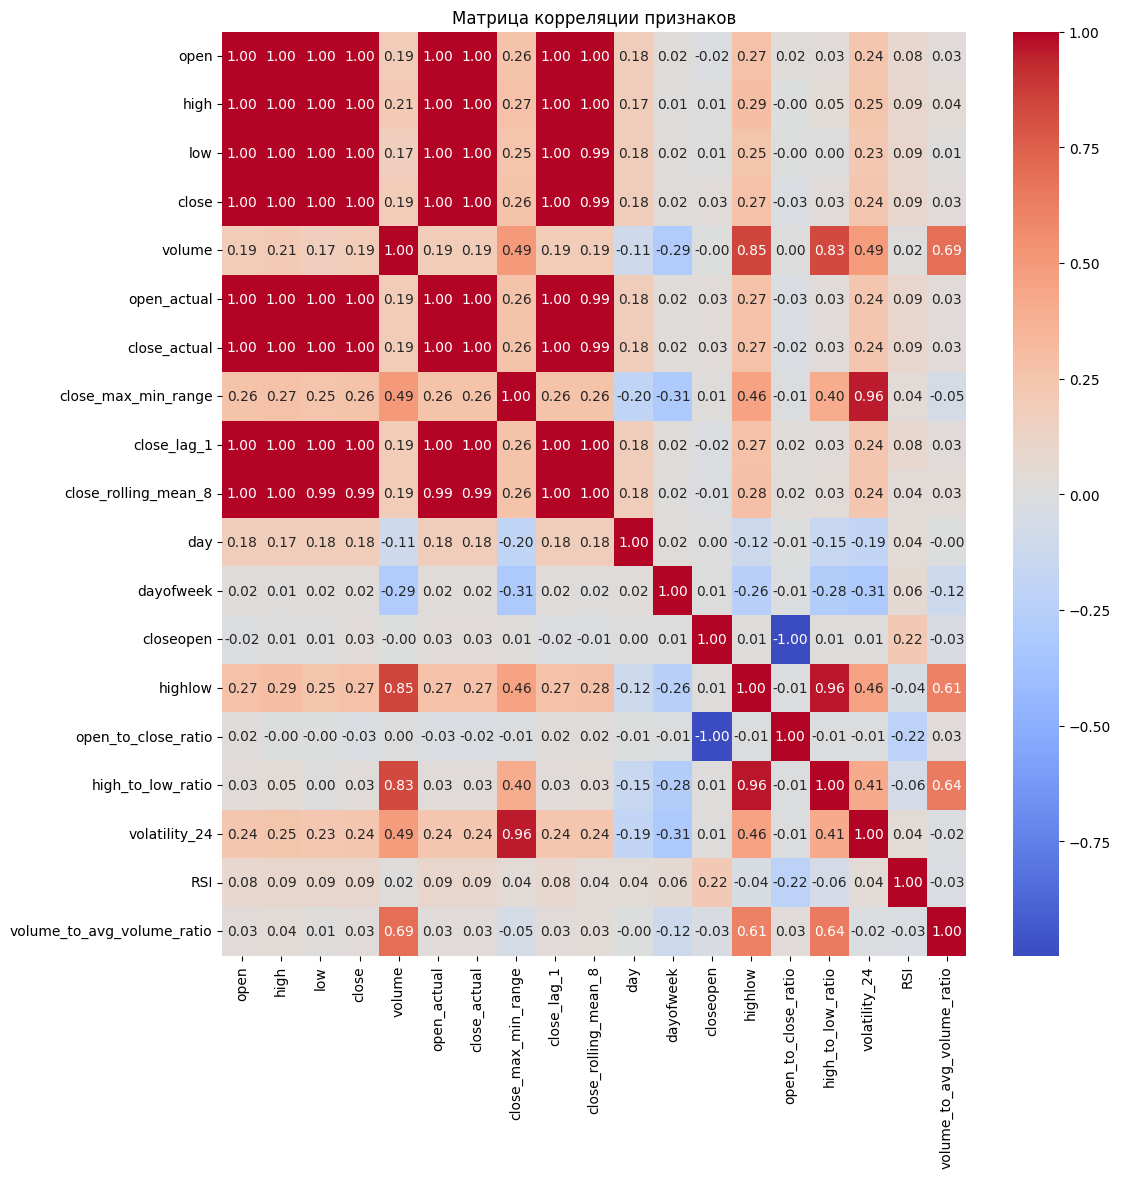

In [12]:
# построим матрицу корреляции между признаками

correlation = data.corr(method='spearman')
plt.figure(figsize=(12, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции признаков')
plt.show();

Лаги более 1 и по столбцам отличным от close - мультиколлинеарны, сразу их исключили. Из представленных в таблице данные по dayoftheweek, close-open, также как и отношения close/open, high/low, volume/avg_volume крайне слабо коррелируют с целевым признаком close, предлагается исключить: 

In [13]:
data = data.drop(columns=['dayofweek', 'closeopen', 'open_to_close_ratio', 'high_to_low_ratio', 'volume_to_avg_volume_ratio'])
data.tail()


,open,high,low,close,volume,open_actual,close_actual,close_max_min_range,close_lag_1,close_rolling_mean_8,day,highlow,volatility_24,RSI
2024-12-16 15:00:00,3930.00,3949.20,3917.95,3941.21,39028.6036,3941.21,3962.41,153.36,3929.99,3931.54125,16,31.25,37.863991,36.789026
2024-12-16 16:00:00,3941.21,3973.00,3939.40,3962.41,31949.4036,3962.42,4033.70,153.36,3941.21,3927.44125,16,33.60,37.977122,48.178959
2024-12-16 17:00:00,3962.42,4042.11,3958.60,4033.70,66377.4354,4033.70,4086.66,153.36,3962.41,3928.76375,16,83.51,42.414263,66.021808
2024-12-16 18:00:00,4033.70,4107.80,4031.71,4086.66,73953.7892,4086.66,4056.88,177.47,4033.70,3940.19125,16,76.09,50.738831,70.264114
2024-12-16 19:00:00,4086.66,4088.22,4033.24,4056.88,48001.6435,4056.89,4048.54,230.43,4086.66,3957.17250,16,54.98,54.296283,63.130871


**Вывод**

По итогу зарузки данных были проанализированы различные источники данных для проекта - выяснилось, что intraday-данные с Quandl и его основного конкурента Alpha_vantage только по платной подписке, Yahoo finance дает неполные данные и только по неактуальным парам - криптовалюта/фиатная валюта, investing.com также дает только дневные данные и на ограниченный период. Поэтому был выбран вариант использования данных по паре ETH/USDT напрямую с Binance.  

Загруженные данные без пропусков, дубликатов, в хронологическом порядке и в удобном формате, сразу распознаваемом стандартными средствами pandas - практически не потребовали предобработки.  

Аномалий выявлено не было, выбросы только по данным объема торгов - и по времени совпадают с периодом сильного падения цены, что закономерно для финансовых рынков.
Проверка на стационарность с помощью визуальных инсрументво и статтестов показала нестационарность (что предполагает возможность дополнительной обработки данных для более точного прогнозирования в будущем).  

Для обучения моделией были добавлены дополнительные признаки - разницы мин и макс значений закрытий за последние 24 часа, даты, целевого признака с часовым лагом и скользящее среднее с 8-часовым окном, показатель волатильности и значение индекса RSI.  

Матрица корреляции Спирмена показала наличие корреляции целевого признака (close) не со всеми признаками: было принято решение удалить - день недели, close-open, также как и отношения close/open, high/low, volume/avg_volume . Среди остальных признаков наибольшая связь целевого признака с предыдущим часом(1.0) и скользящим средним(0.98), остальные признаки имеют менее выраженную связь.


<a id='Разделение-данных-на-обучающую-и-тестовую-выборки.'></a> 
## Разделение данных на обучающую и тестовую выборки.
[К содержанию](#К-содержанию) 

In [14]:
# объявим константы, отделим признаки и масшабируем данные
RANDOM_STATE = 1
time_steps = 4
n_splits = 4

X = data.drop('close_actual', axis=1)
y = data['close_actual']

X_train_i, X_test_final_i, y_train_i, y_test_final_i = train_test_split(X, y, test_size=0.1, shuffle=False)

X_train = X_train_i.values
X_test_final = X_test_final_i.values
y_train = y_train_i.values
y_test_final = y_test_final_i.values

# масштабирование 
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

<a id='Создание-модели-LSTM-с-использованием-PyTorch-и-обучение.'></a> 
## Создание модели LSTM с использованием PyTorch и обучение.
[К содержанию](#К-содержанию) 

In [15]:
# функция создания последовательностей для LSTM
def create_sequences(data, target, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(data) - time_steps):
        X_seq.append(data[i:i + time_steps])
        y_seq.append(target[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# создаем последовательности
X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)

# делим данные последовательно для временного ряда
tss = TimeSeriesSplit(n_splits=n_splits)
rmse_scores_train = []
rmse_scores_test = []
r2_scores_train = []
r2_scores_test = []

for train_idx, test_idx in tss.split(X_seq):
    X_train_s, X_test_s = X_seq[train_idx], X_seq[test_idx]
    y_train_s, y_test_s = y_seq[train_idx], y_seq[test_idx]

    # конвертируем данные в тензоры для pytorch
    X_train_tensor = torch.tensor(X_train_s, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_s, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_s, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_s, dtype=torch.float32).view(-1, 1)

    # фомируем модель LSTM
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(LSTMModel, self).__init__()
            self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
            self.dropout1 = nn.Dropout(0.2)
            self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
            self.dropout2 = nn.Dropout(0.2)
            self.fc1 = nn.Linear(hidden_size, 128)
            self.fc2 = nn.Linear(128, output_size)

        def forward(self, x):
            x, _ = self.lstm1(x)
            x = self.dropout1(x)
            x, _ = self.lstm2(x)
            x = self.dropout2(x)
            x = x[:, -1, :]
            x = self.fc1(x)
            x = torch.relu(x)
            x = self.fc2(x)
            return x

    # инициализация модели
    input_size = X_train_s.shape[2]
    hidden_size = 256
    output_size = 1
    model = LSTMModel(input_size, hidden_size, output_size)

    # задаем функцию потерь и оптимизатор
    criterion = nn.MSELoss()
    #criterion = nn.HuberLoss(delta=1.0)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # обучение модели
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

        # вычисление RMSE на тренировочных данных
        if (epoch + 1) % 10 == 0:
            # разворачиваем масштабированные значения
            y_train_original = scaler_y.inverse_transform(y_train_tensor.detach().numpy().reshape(-1, 1))
            y_train_pred_original = scaler_y.inverse_transform(output.detach().numpy().reshape(-1, 1))

            # вычисление RMSE и R2 на развернутых данных
            train_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
            train_r2 = r2_score(y_train_original, y_train_pred_original)
            print(f"Эпоха [{epoch + 1}/{num_epochs}], Потеря: {loss.item():.4f}, RMSE (train): {train_rmse:.4f}, R2 (train): {train_r2:.4f}")
    
    # вычисление RMSE на тестовых данных после обучения
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        
        # разворачиваем масштабированные прогнозы
        y_test_original = scaler_y.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
        y_pred_original = scaler_y.inverse_transform(y_pred.numpy().reshape(-1, 1))

        # вычисление RMSE и R2 на развернутых данных
        test_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
        test_r2 = r2_score(y_test_original, y_pred_original)
        print(f"RMSE на тестовых данных: {test_rmse:.4f}, R2 на тестовых данных: {test_r2:.4f}  \n")

    rmse_scores_train.append(train_rmse)
    rmse_scores_test.append(test_rmse)
    r2_scores_train.append(train_r2)
    r2_scores_test.append(test_r2)


# вывод средней метрики RMSE для всех фолдов
print(f"Средний RMSE на тренировочных данных: {np.mean(rmse_scores_train):.4f}, Средний R2 на тренировочных данных: {np.mean(r2_scores_train):.4f}")
print(f"Средний RMSE на тестовых данных: {np.mean(rmse_scores_test):.4f}, Средний R2 на тестовых данных: {np.mean(r2_scores_test):.4f}")

Эпоха [10/100], Потеря: 0.3365, RMSE (train): 235.7542, R2 (train): -0.4990
Эпоха [20/100], Потеря: 0.0498, RMSE (train): 90.6802, R2 (train): 0.7782
Эпоха [30/100], Потеря: 0.0303, RMSE (train): 70.8054, R2 (train): 0.8648
Эпоха [40/100], Потеря: 0.0291, RMSE (train): 69.3612, R2 (train): 0.8702
Эпоха [50/100], Потеря: 0.0152, RMSE (train): 50.0881, R2 (train): 0.9323
Эпоха [60/100], Потеря: 0.0114, RMSE (train): 43.4408, R2 (train): 0.9491
Эпоха [70/100], Потеря: 0.0092, RMSE (train): 39.0026, R2 (train): 0.9590
Эпоха [80/100], Потеря: 0.0085, RMSE (train): 37.5613, R2 (train): 0.9619
Эпоха [90/100], Потеря: 0.0085, RMSE (train): 37.4617, R2 (train): 0.9621
Эпоха [100/100], Потеря: 0.0082, RMSE (train): 36.8275, R2 (train): 0.9634
RMSE на тестовых данных: 184.2610, R2 на тестовых данных: 0.7659  

Эпоха [10/100], Потеря: 0.3517, RMSE (train): 241.0336, R2 (train): 0.5382
Эпоха [20/100], Потеря: 0.0595, RMSE (train): 99.1682, R2 (train): 0.9218
Эпоха [30/100], Потеря: 0.0247, RMSE (tr

**Вывод**

С учетом проведенной кросс-валидаци и ручного подбора гиперпараметров(количество эпох обучения, количество нейронов в слоях и самих слоев сети) средние метрики получились RMSE - 82.3, r2 - 0.85. Далее проведем тестирование на изначально выделенной тестовой выборке, которая вообще не присутствовала в обучающем наборе.

<a id='Прогноз-на-тестовой-выборке.-Расчет-метрик-качества.'></a> 
## Прогноз на тестовой выборке. Расчет метрик качества.
[К содержанию](#К-содержанию)

Перед тестированием необходимо заново обучить выбранную модель на всем тренировочном датасете (так как при кросс-валидации мы его дробили для подбора гиперпараметров).

In [16]:
# формируем последовательности
X_seq_full, y_seq_full = create_sequences(X_train_scaled, y_train_scaled, time_steps)

# преобразуем в тензоры
X_full_tensor = torch.tensor(X_seq_full, dtype=torch.float32)
y_full_tensor = torch.tensor(y_seq_full, dtype=torch.float32).view(-1, 1)

# обучение модели
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_full_tensor)
    loss = criterion(output, y_full_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        y_full_original = scaler_y.inverse_transform(y_full_tensor.detach().numpy().reshape(-1, 1))
        y_full_pred_original = scaler_y.inverse_transform(output.detach().numpy().reshape(-1, 1))
        full_rmse = np.sqrt(mean_squared_error(y_full_original, y_full_pred_original))
        full_r2 = r2_score(y_full_original, y_full_pred_original)
        print(f"Эпоха [{epoch + 1}/{num_epochs}], Потеря: {loss.item():.4f}, RMSE: {full_rmse:.4f}, R2: {full_r2:.4f}")

Эпоха [10/100], Потеря: 0.0090, RMSE: 38.6005, R2: 0.9910
Эпоха [20/100], Потеря: 0.0088, RMSE: 38.0993, R2: 0.9912
Эпоха [30/100], Потеря: 0.0087, RMSE: 37.8042, R2: 0.9913
Эпоха [40/100], Потеря: 0.0084, RMSE: 37.1851, R2: 0.9916
Эпоха [50/100], Потеря: 0.0081, RMSE: 36.6070, R2: 0.9919
Эпоха [60/100], Потеря: 0.0080, RMSE: 36.2462, R2: 0.9920
Эпоха [70/100], Потеря: 0.0080, RMSE: 36.3279, R2: 0.9920
Эпоха [80/100], Потеря: 0.0080, RMSE: 36.2854, R2: 0.9920
Эпоха [90/100], Потеря: 0.0075, RMSE: 35.1509, R2: 0.9925
Эпоха [100/100], Потеря: 0.0074, RMSE: 35.0786, R2: 0.9925


In [17]:
# масштабирование тестовой выборки признаков
X_test_final_scaled = scaler_X.transform(X_test_final)

# создаем последовательности и тензоры для тестового набора данных
X_test_seq, _ = create_sequences(X_test_final_scaled, np.zeros(len(X_test_final_scaled)), time_steps)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)

# делаем прогноз на тестовом наборе данных
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

# разворачиваем прогнозы с учетом масштабирования
y_pred_original = scaler_y.inverse_transform(y_pred.numpy().reshape(-1, 1)).flatten()

# корректируем целевые значения
y_test_final_trimmed = y_test_final[time_steps:]

# считаем метрики
rmse = np.sqrt(mean_squared_error(y_test_final_trimmed, y_pred_original))
test_r2 = r2_score(y_test_final_trimmed, y_pred_original)

print(f'Метрика RMSE на финальных тестовых данных: {rmse:.3f}, R2 на финальных тестовых данных: {test_r2:.4f}\n')

Метрика RMSE на финальных тестовых данных: 79.630, R2 на финальных тестовых данных: 0.6968



Метрика RMSE на тестовых данных не самая лучшая - 79.6, но в целом модель работает, значение R2 - 0.70 также показывает потенциал для улучшения модели. Визуализируем прогнозы:

<a id='Визуализация-результатов-и-сравнение-прогноза-модели-с-реальными-значениями.'></a> 
## Визуализация результатов и сравнение прогноза модели с реальными значениями.
[К содержанию](#К-содержанию) 

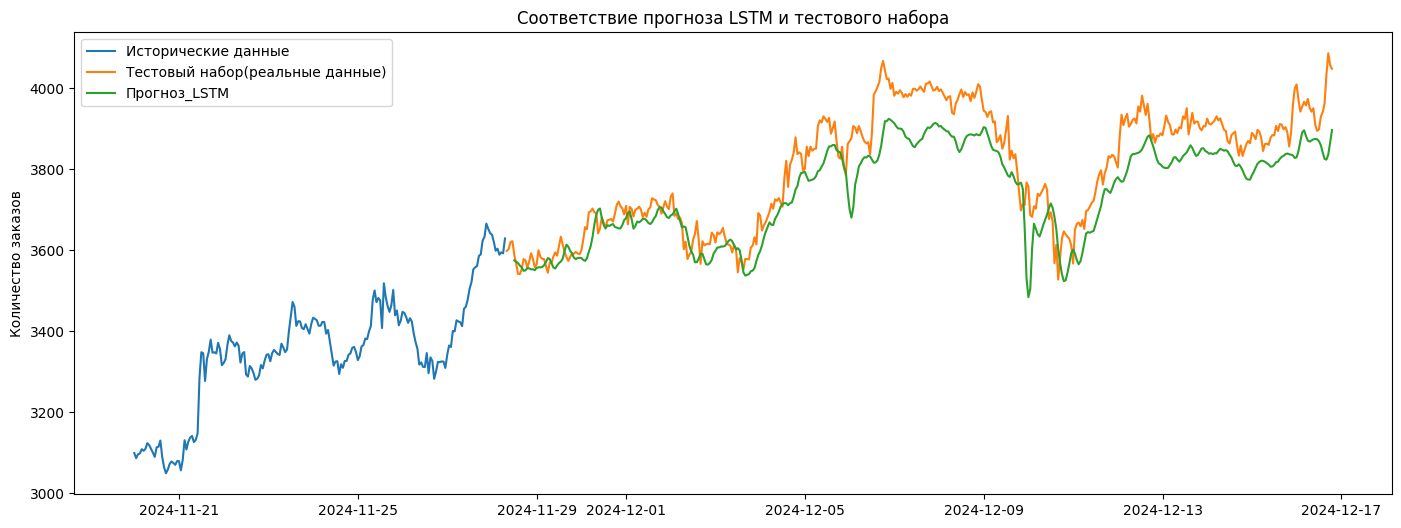

In [18]:
forecast_index = y_test_final_i[time_steps:].index
forecast_series = pd.Series(y_pred_original, index=forecast_index)

# посмотрим на графиках соответствия моделей тестовым данным
plt.figure(figsize=(17, 6))

plt.title('Соответствие прогноза LSTM и тестового набора')
sns.lineplot(data=y_train_i.iloc[-200:], label='Исторические данные')
sns.lineplot(data=y_test_final_i, label='Тестовый набор(реальные данные)')
sns.lineplot(data=forecast_series, label='Прогноз_LSTM')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

In [19]:
# также проверим модель на адекватность с помощью DummyRegressor
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train,y_train)
y_pred_d = dummy_regr.predict(X_test_final)

# считаем метрику на тестовых данных
rmse_d = np.sqrt(mean_squared_error(y_test_final, y_pred_d))
print(f'Метрика RMSE константной модели на тестовых данных: {rmse_d:.3f}')

Метрика RMSE константной модели на тестовых данных: 1144.555


<a id='Общий-вывод'></a> 
## Общий вывод
[К содержанию](#К-содержанию) 



По итогу **зарузки данных** были проанализированы различные источники данных для проекта - выяснилось, что intraday-данные с Quandl и его основного конкурента Alpha_vantage только по платной подписке, Yahoo finance дает неполные данные и только по неактуальным парам - криптовалюта/фиатная валюта, investing.com также дает только дневные данные и на ограниченный период. Поэтому был выбран вариант использования данных по паре ETH/USDT напрямую с Binance.  

Загруженные данные без пропусков, дубликатов, в хронологическом порядке и в удобном формате, сразу распознаваемом стандартными средствами pandas - практически не потребовали предобработки.  

Аномалий выявлено не было, выбросы только по данным объема торгов - и по времени совпадают с периодом сильного падения цены, что закономерно для финансовых рынков.
Проверка на стационарность с помощью визуальных инсрументво и статтестов показала нестационарность (что предполагает возможность дополнительной обработки данных для более точного прогнозирования в будущем - дифференцирование, преобразования Бокса-Кокса, тем более для LSTM).  

Датасет был преобразован для прогнозирования будущих цен (целевой признак - close c учетом сдвига на 1 позицию назад) и с учетом наличия при текущем часе только цены открытия.
Для обучения моделей были добавлены дополнительные признаки - разницы мин и макс значений закрытий за последние 24 часа, даты, целевого признака с часовым лагом и скользящее среднее с 8-часовым окном, показатель волатильности и значение индекса RSI.  

**Матрица корреляции** Спирмена показала наличие корреляции целевого признака (close) не со всеми признаками: было принято решение удалить - день недели, close-open, также как и отношения close/open, high/low, volume/avg_volume . Среди остальных признаков наибольшая связь целевого признака с предыдущим часом(1.0) и скользящим средним(0.98), остальные признаки имеют менее выраженную связь.

Далее из данных выделили 10% для финального теста, и разделили оставшиеся данные на обучающую и валидационную выборки дя проведения кросс-валидации. Для обучения была **сформирована модель** на базе 2 LSTM слоев с 256 нейронами, слоями dropout для регуляризации и 1 Dense слоем с 128 нейронами, с функцией потерь MSE и оптимизирующей функцией Adam и количеством запоминаемых временных шагов 4. Для кросс-валидаци временной ряд был разделен на 4 последовательных фолда.  

**Метриками** для оценки качества модели были использованы RMSE и R2 - достаточно стандартные метрики для оценки качества прогнозирования временных рядов, регрессий: RMSE - в том же масштабе, что и целевой признак и сильнее штрафует за большие ошибки, R2 - хорошо объясняет каество модели и потенциал для улучшений.
С учетом проведенной кросс-валидаци и ручного подбора гиперпараметров(количество эпох обучения, количество нейронов в слоях и самих слоев сети) средние метрики получились RMSE - 82.3, r2 - 0.85.  

Для тестирования была обучена модель на всех данных. **Итоговая метрика RMSE** на тестовых данных не самая лучшая - **79.6**, но в целом модель работает, значение **R2 - 0.70** также показывает потенциал для улучшения модели. Далее также была проведена визуализация результатов прогнозирования - график фактических и прогнозируемых значений, а также сравнение с константной моделью, которая показала RMSE - 1144.  

В целом, **модель работает, но есть потенциал для улучшения**, например, за счет добавления дополнительных более сложных признаков, дополнительных преобразований временного ряда для приведения его к более стационарному (дифференцирование и Бокса-Кокса), а также более обширного перебора гиперпараметров и глубины нейронной сети.